#### Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import re

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#### Plots

In [12]:
def plot_generator_training(path):

    epochs = []
    nlls = []

    with open(path, 'r') as file:
        for line in file:
            if line.startswith('epoch:'):
                # Split the line and extract epoch and nll values
                parts = line.split()
                epochs.append(int(parts[1]))
                nlls.append(float(parts[3]))

    # Create the plot
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, nlls)
    plt.title('Training Progress: Negative Log-Likelihood (NLL)')
    plt.xlabel('Epoch')
    plt.ylabel('Negative Log-Likelihood')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_discriminator_training(path):

    epochs = []
    loss = []
    accuracy = []
    real_prob = []
    fake_prob = []

    with open(path, 'r') as file:
        for line in file:
            if line.startswith('epoch:'):
                # Split the line and extract epoch and nll values
                parts = line.split()
                epochs.append(int(parts[1]))
                loss.append(float(parts[3]))
                accuracy.append(float(parts[5]))
                real_prob.append(float(parts[7]))
                fake_prob.append(float(parts[9]))

    # Create a figure with subplots in one row
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,4))
    axs = axs.flatten()
    
    # Plot loss over time
    axs[0].plot(epochs, loss, color='b')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)
    
    # Plot accuracy over time
    axs[1].plot(epochs, accuracy, color='b')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(0, 1.05)
    axs[1].grid(True)
    
    # Plot real and fake probabilities over time
    axs[2].plot(epochs, real_prob, label='Real Samples', color='g')
    axs[2].plot(epochs, fake_prob, label='Fake Samples', color='r')
    axs[2].set_title('Probabilities')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Probability')
    axs[2].grid(True)
    axs[2].set_ylim(-0.05, 1.05)
    axs[2].legend()
    
    plt.show()


#### Target LSTM

In [3]:
class TargetLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, sequence_length, start_token, device='cpu'):
        
        super(TargetLSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = start_token
        self.device = device
        
        # Define layers
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
        
        # Initialize on device
        self.to(device)
       
    def forward(self, x, hidden=None):

        emb = self.embeddings(x)                    # [batch_size, sequence_length, embedding_dim]
        lstm_out, hidden = self.lstm(emb, hidden)   # lstm_out: [batch_size, sequence_length, hidden_dim]
        logits = self.output_layer(lstm_out)        # [batch_size, sequence_length, vocab_size]
        
        return logits, hidden
    
    def generate(self, num_samples):

        with torch.no_grad():
            
            # Start token for all sequences
            x = torch.full((num_samples, 1), self.start_token, dtype=torch.long, device=self.device)
            hidden = None  # Let PyTorch initialize the hidden state

            generated_sequences = torch.zeros(num_samples, self.sequence_length, dtype=torch.long, device=self.device)

            for i in range(self.sequence_length):
                # Forward pass
                emb = self.embeddings(x[:, -1:])  # Only use the last token
                lstm_out, hidden = self.lstm(emb, hidden)
                logits = self.output_layer(lstm_out)
                
                # Sample from distribution
                probs = F.softmax(logits.squeeze(1), dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                # Add to sequence
                generated_sequences[:, i] = next_token.squeeze()
                
                # Update input for next step (only need the current token, not the entire history)
                x = next_token
            
            return generated_sequences

    def calculate_nll(self, generated_sequences):

        with torch.no_grad():
            # Use all tokens except the last one as input
            inputs = generated_sequences[:, :-1]
            
            # Use all tokens except the first one as targets
            targets = generated_sequences[:, 1:]
            
            # Forward pass
            logits, _ = self.forward(inputs)
            
            # Calculate negative log-likelihood
            nll = F.cross_entropy(logits.reshape(-1, self.vocab_size), targets.reshape(-1), reduction='mean')
            
            return nll.item()

    def load_params(self, params_path):
        """
        Load parameters from a TensorFlow list format.
        """
        try:
            with open(params_path, 'rb') as f:
                try:
                    params = pickle.load(f)
                except UnicodeDecodeError:
                    f.seek(0)
                    params = pickle.load(f, encoding='latin1')
        except Exception as e:
            print(f"Error loading pickle file: {str(e)}")
            return self
        
        with torch.no_grad():
            # 1. Embeddings
            self.embeddings.weight.copy_(torch.tensor(params[0], dtype=torch.float32))
            
            # 2. LSTM Parameters
            # Extract individual LSTM weights
            Wi, Ui, bi = params[1], params[2], params[3]  # Input gate
            Wf, Uf, bf = params[4], params[5], params[6]  # Forget gate
            Wo, Uo, bo = params[7], params[8], params[9]  # Output gate
            Wc, Uc, bc = params[10], params[11], params[12]  # Cell state
            
            # Concatenate the weights in PyTorch's expected format
            weight_ih = np.vstack([Wi, Wf, Wc, Wo])
            weight_hh = np.vstack([Ui, Uf, Uc, Uo])
            
            # Bias is also concatenated
            bias_ih = np.concatenate([bi, bf, bc, bo])
            bias_hh = np.zeros_like(bias_ih)
            
            # Copy to PyTorch model
            self.lstm.weight_ih_l0.copy_(torch.tensor(weight_ih, dtype=torch.float32))
            self.lstm.weight_hh_l0.copy_(torch.tensor(weight_hh, dtype=torch.float32))
            self.lstm.bias_ih_l0.copy_(torch.tensor(bias_ih, dtype=torch.float32))
            self.lstm.bias_hh_l0.copy_(torch.tensor(bias_hh, dtype=torch.float32))
            
            # 3. Output layer
            self.output_layer.weight.copy_(torch.tensor(params[13].T, dtype=torch.float32))
            self.output_layer.bias.copy_(torch.tensor(params[14], dtype=torch.float32))
        
        return self

    def save_params(self, path):
        torch.save(self.state_dict(), path)
        
    def save_samples(self, samples, file_path):
        with open(file_path, 'w') as f:
            for sample in samples.cpu().numpy():
                f.write(' '.join([str(int(x)) for x in sample]) + '\n')



#### Generator

In [4]:
class Generator(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, sequence_length, start_token, device):
        
        super(Generator, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = start_token
        self.device = device
        
        # Define layers
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
                
        # Initialize on device
        self.to(device)
       
    def forward(self, x, hidden=None):

        emb = self.embeddings(x)                    # [batch_size, sequence_length, embedding_dim]
        lstm_out, hidden = self.lstm(emb, hidden)   # lstm_out: [batch_size, sequence_length, hidden_dim]
        logits = self.output_layer(lstm_out)        # [batch_size, sequence_length, vocab_size]
        
        return logits, hidden
    
    def generate(self, num_samples):

        with torch.no_grad():
            
            # Start token for all sequences
            x = torch.full((num_samples, 1), self.start_token, dtype=torch.long, device=self.device)
            hidden = None  # Let PyTorch initialize the hidden state

            generated_sequences = torch.zeros(num_samples, self.sequence_length, dtype=torch.long, device=self.device)

            for i in range(self.sequence_length):
                # Forward pass
                emb = self.embeddings(x[:, -1:])  # Only use the last token
                lstm_out, hidden = self.lstm(emb, hidden)
                logits = self.output_layer(lstm_out)
                
                # Sample from distribution
                probs = F.softmax(logits.squeeze(1), dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                # Add to sequence
                generated_sequences[:, i] = next_token.squeeze()
                
                # Update input for next step (only need the current token, not the entire history)
                x = next_token
            
            return generated_sequences

    def pretrain_step(self, x, optimizer):

        optimizer.zero_grad()
            
        inputs = x[:, :-1]                  # Forward pass - input is all tokens except last one
        targets = x[:, 1:].contiguous()     # Target is all tokens except first one (shifted by 1)
        
        logits, _ = self.forward(inputs)
    
        loss = F.cross_entropy(logits.reshape(-1, self.vocab_size), targets.reshape(-1))
        
        loss.backward()
        optimizer.step()
        
        return loss.item()

def pretrain_generator(target_lstm, generator, optimizer, pre_epoch_num, batch_size, generated_num, eval_freq, lr_patience, lr_decay):
    
    print('Start pre-training...')

    # Open log file
    log = open('NEW_experiment-log.txt', 'w')
    log.write('pre-training...\n')

    # For learning rate scheduling
    best_loss = float('inf')
    patience_counter = 0
        
    
    # Generate Oracle Data
    target_lstm.eval()
    oracle_data = target_lstm.generate(generated_num)
    
    # Create DataLoader
    oracle_dataset = torch.utils.data.TensorDataset(oracle_data)
    oracle_loader = torch.utils.data.DataLoader(
        oracle_dataset, 
        batch_size=batch_size,
        shuffle=True
    )
    
    # Training loop
    for epoch in range(pre_epoch_num):

        epoch_loss = 0
        batch_count = 0

        # Evaluate using the oracle every eval_freq epochs
        if epoch % eval_freq == 0 or epoch == pre_epoch_num - 1:

            generated_samples = generator.generate(int(generated_num/10))
            
            # Calculate NLL using the oracle
            nll = target_lstm.calculate_nll(generated_samples)
            print(f'Epoch {epoch}, NLL: {nll:.4f}')

            # Log to file
            buffer = f'epoch:\t{epoch}\tnll:\t{nll:.5f}\n'
            log.write(buffer)
            log.flush()  # Ensure it's written immediately
        
        # Train on all batches
        for batch_data in oracle_loader:
            x = batch_data[0]
            loss = generator.pretrain_step(x, optimizer)
            epoch_loss += loss
            batch_count += 1
        
        # Calculate average loss for this epoch
        avg_loss = epoch_loss / batch_count
        #print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}')

        # Learning rate scheduling
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= lr_patience:
            # Reduce learning rate
            for param_group in optimizer.param_groups:
                param_group['lr'] *= lr_decay
            print(f"Learning rate reduced to {optimizer.param_groups[0]['lr']}")
            patience_counter = 0

    log.close()    
    print('Pretraining finished!')
    


#### Discriminator

In [5]:
class Discriminator(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, device='cpu'):
        
        super(Discriminator, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.device = device
        
        # Embedding layer
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer - added num_layers parameter
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0  # Dropout between LSTM layers
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )
        
        # Move to device
        self.to(device)
    
    def forward(self, x):

        # Embedding
        embedded = self.embeddings(x)                       # [batch_size, sequence_length, embedding_dim]
        
        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(embedded)      # hidden: [num_layers, batch_size, hidden_dim]
        
        # Use the final hidden state from the last layer
        final_hidden = hidden[-1]                           # [batch_size, hidden_dim]
        
        # Classification
        logits = self.classifier(final_hidden)              # [batch_size, 1]
        
        return logits.squeeze(-1)                           # [batch_size]
    
    def get_reward(self, x):

        with torch.no_grad():
            logits = self.forward(x)
            rewards = torch.sigmoid(logits)     # Get the probabilities
            return rewards
    
    def train_step(self, real_data, generated_data, optimizer):

        optimizer.zero_grad()
        
        # Prepare inputs and targets
        batch_size = real_data.size(0)

        inputs = torch.cat([real_data, generated_data], dim=0)

        targets = torch.cat([
            torch.ones(batch_size, device=self.device), 
            torch.zeros(batch_size, device=self.device)
        ], dim=0)
        
        # Forward pass
        logits = self.forward(inputs)
        
        # Calculate loss
        loss = F.binary_cross_entropy_with_logits(logits, targets)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        return loss.item()

def evaluate_discriminator(discriminator, target_lstm, generator, num_samples, device):
    
    discriminator.eval()
    target_lstm.eval()
    generator.eval()
    
    with torch.no_grad():
        # Generate data
        real_data = target_lstm.generate(num_samples).to(device)
        fake_data = generator.generate(num_samples).to(device)
        
        # Get predictions - using get_reward to get probabilities
        real_preds = discriminator.get_reward(real_data)
        fake_preds = discriminator.get_reward(fake_data)
        
        # Calculate metrics
        real_correct = (real_preds >= 0.5).sum().item()
        fake_correct = (fake_preds < 0.5).sum().item()
        
        accuracy = (real_correct + fake_correct) / (2 * num_samples)
        real_prob = real_preds.mean().item()
        fake_prob = fake_preds.mean().item()
    
    metrics = {
        'accuracy': accuracy,
        'real_prob': real_prob,
        'fake_prob': fake_prob
    }
    
    return metrics

def pretrain_discriminator(target_lstm, generator, discriminator, optimizer, outer_epochs, inner_epochs, batch_size, generated_num, log_file, device):
    
    print('Start pre-training discriminator...')
    
    # Open log file
    log = open(log_file, 'w')
    log.write('Discriminator pre-training...\n')
    
    # Initial evaluation
    metrics = evaluate_discriminator(discriminator, target_lstm, generator, num_samples=1000, device=device)
    print(f"Initial accuracy: {metrics['accuracy']:.4f}")
    
    total_epochs = 0
    
    # Outer loop (50 times)
    for outer_epoch in range(outer_epochs):

        # Generate positive samples from the oracle (only once)
        target_lstm.eval()
        with torch.no_grad():
            positive_samples = target_lstm.generate(generated_num)
            
        # Generate new negative samples for each outer epoch
        generator.eval()
        with torch.no_grad():
            negative_samples = generator.generate(generated_num)
        
        # Create data loaders for this outer epoch
        pos_dataset = torch.utils.data.TensorDataset(positive_samples)
        neg_dataset = torch.utils.data.TensorDataset(negative_samples)
        pos_loader = torch.utils.data.DataLoader(pos_dataset, batch_size=batch_size, shuffle=True)
        neg_loader = torch.utils.data.DataLoader(neg_dataset, batch_size=batch_size, shuffle=True)
        
        for inner_epoch in range(inner_epochs):
            
            # Set discriminator to training mode
            discriminator.train()
            
            total_loss = 0
            num_batches = 0
            
            # Iterate through batches (same data for all inner epochs)
            for (pos_batch,), (neg_batch,) in zip(pos_loader, neg_loader):
                loss = discriminator.train_step(pos_batch, neg_batch, optimizer)
                total_loss += loss
                num_batches += 1
            
            total_epochs += 1
            avg_loss = total_loss / num_batches if num_batches > 0 else 0
            eval_metrics = evaluate_discriminator(discriminator, target_lstm, generator, num_samples=1000, device=device)
            
            log_str = f'epoch:\t{total_epochs}\tloss:\t{avg_loss:.4f}\t'
            log_str += f'accuracy:\t{eval_metrics["accuracy"]:.4f}\t'
            log_str += f'real_prob\t{eval_metrics["real_prob"]:.4f}\tfake_prob\t{eval_metrics["fake_prob"]:.4f}'
            
            print(log_str)
            log.write(log_str + '\n')
            log.flush()
    
    log.close()
    
    print('Discriminator pretraining finished!')

#### Pretraining

In [6]:
# Initialize models
VOCAB_SIZE = 5000
EMB_DIM = 32 
HIDDEN_DIM = 32 
SEQ_LENGTH = 20 
START_TOKEN = 0
PRE_EPOCH_NUM = 250
BATCH_SIZE = 64
SEED = 88
set_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generated_num = 5000

# Discriminator hyperparameters
DIS_EMB_DIM = 64
DIS_HIDDEN_DIM = 128
DIS_NUM_LAYERS = 1
DIS_DROPOUT = 0.1
DIS_BATCH_SIZE = 64
OUTER_EPOCHS = 20
INNER_EPOCHS = 1

# Create models
target_lstm = TargetLSTM(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN, device)
target_lstm.load_params(params_path='save/target_params_py3.pkl')
generator = Generator(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN, device)
discriminator = Discriminator(VOCAB_SIZE, DIS_EMB_DIM, DIS_HIDDEN_DIM, DIS_NUM_LAYERS, DIS_DROPOUT, device)


# Initialize optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.01)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=3e-4)

# PRETRAINING
#pretrain_generator(target_lstm, generator, g_optimizer, PRE_EPOCH_NUM, BATCH_SIZE, generated_num, eval_freq=5, lr_patience=5, lr_decay=0.5)

pretrain_discriminator(target_lstm, generator, discriminator, d_optimizer, OUTER_EPOCHS, INNER_EPOCHS, DIS_BATCH_SIZE, generated_num, 'discriminator_pretrain.txt', device)

Start pre-training discriminator...
Initial accuracy: 0.4965
epoch:	1	loss:	0.6912	accuracy:	0.5810	real_prob	0.5041	fake_prob	0.4978
epoch:	2	loss:	0.6047	accuracy:	0.7690	real_prob	0.6848	fake_prob	0.3218
epoch:	3	loss:	0.3921	accuracy:	0.8900	real_prob	0.8170	fake_prob	0.1493
epoch:	4	loss:	0.2196	accuracy:	0.9390	real_prob	0.9214	fake_prob	0.1301
epoch:	5	loss:	0.1547	accuracy:	0.9515	real_prob	0.8944	fake_prob	0.0523
epoch:	6	loss:	0.1300	accuracy:	0.9620	real_prob	0.9430	fake_prob	0.0693
epoch:	7	loss:	0.1031	accuracy:	0.9755	real_prob	0.9660	fake_prob	0.0606
epoch:	8	loss:	0.0894	accuracy:	0.9695	real_prob	0.9551	fake_prob	0.0581
epoch:	9	loss:	0.0806	accuracy:	0.9750	real_prob	0.9611	fake_prob	0.0497
epoch:	10	loss:	0.0758	accuracy:	0.9710	real_prob	0.9407	fake_prob	0.0330
epoch:	11	loss:	0.0712	accuracy:	0.9760	real_prob	0.9661	fake_prob	0.0475
epoch:	12	loss:	0.0675	accuracy:	0.9755	real_prob	0.9505	fake_prob	0.0272
epoch:	13	loss:	0.0632	accuracy:	0.9785	real_prob	0.9756	fak

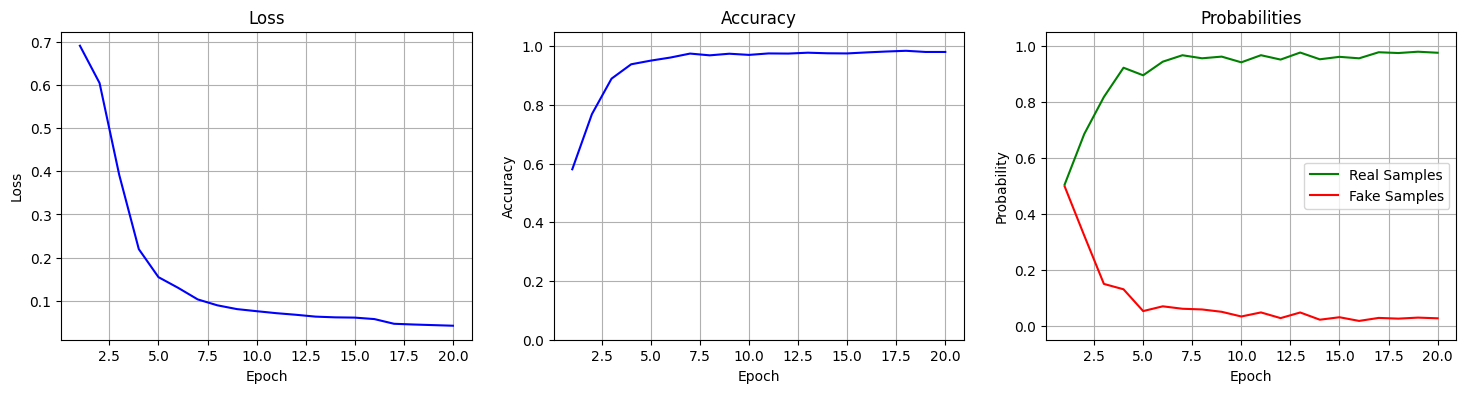

In [13]:
plot_discriminator_training('discriminator_pretrain.txt')

#### 1. CHECK WHICH ONE PRETRAINED FIRST AND CODE ACCORDINGLY.
#### 2. CHECK IF YOU CAN INCLUDE DENSE REWARDS FOR LATER USE
#### 3. INTRODUCE REINFORCE ALGORITHM / ROLLOUT / MC SEARCH



#### OTHER

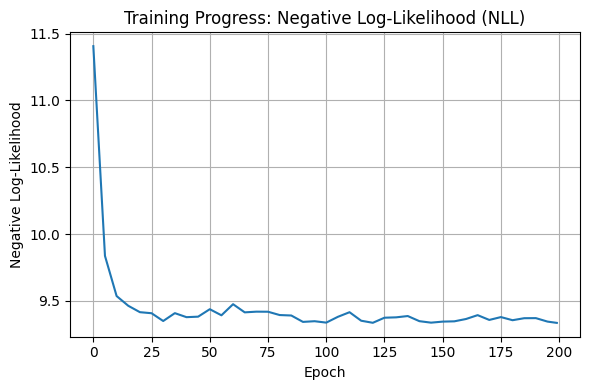

In [7]:
plot_training('NEW_experiment-log.txt')

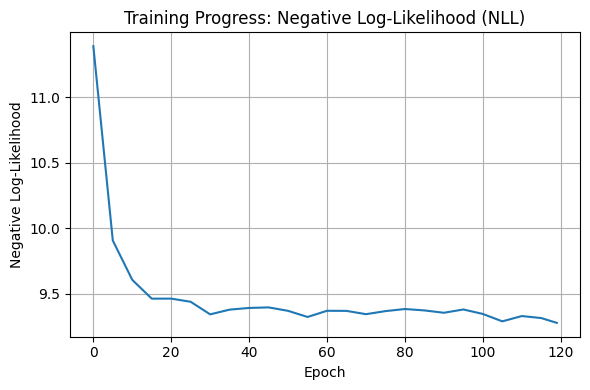

In [18]:
plot_training('NEW_experiment-log.txt')

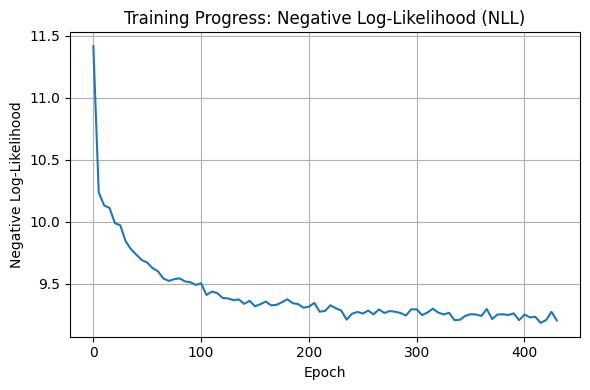

In [6]:
plot_training('NEW_experiment-log.txt')

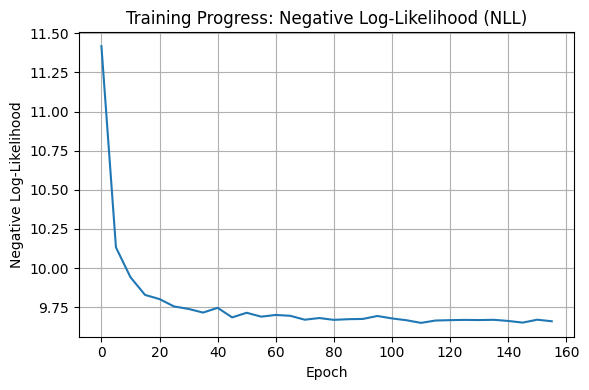

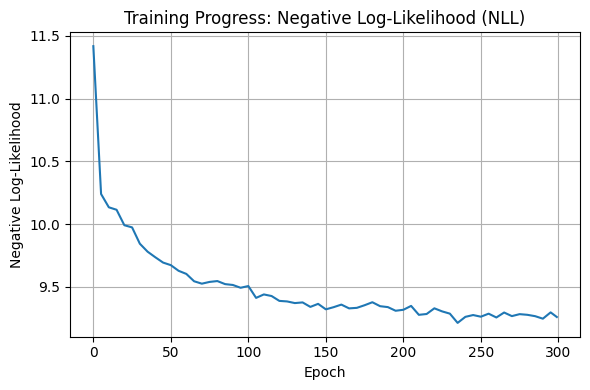

In [11]:
plot_training('NEW_experiment-log.txt')

In [24]:
class Highway(nn.Module):

    def __init__(self, size, bias=-2.0):        # Initialize gate bias to negative value to start with 
        
        super(Highway, self).__init__()
        self.transform_gate = nn.Linear(size, size)
        self.highway_layer = nn.Linear(size, size)
        nn.init.constant_(self.transform_gate.bias, bias)
        
    def forward(self, x):
        
        transform_gate = torch.sigmoid(self.transform_gate(x))
        highway_layer_output = F.relu(self.highway_layer(x))
        
        return transform_gate * highway_layer_output + (1 - transform_gate) * x


class Discriminator(nn.Module):

    def __init__(self, vocab_size, embedding_dim, filter_sizes, num_filters, sequence_length, dropout_prob, highway_layers, l2_reg_lambda, device='cpu'):

        super(Discriminator, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.sequence_length = sequence_length
        self.dropout_prob = dropout_prob
        self.l2_reg_lambda = l2_reg_lambda
        self.device = device
        
        # Word embeddings
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(
                in_channels=1, 
                out_channels=num_filters[i], 
                kernel_size=(filter_size, embedding_dim), 
                stride=1
            ) for i, filter_size in enumerate(filter_sizes)
        ])
        
        
        self.num_filters_total = sum(num_filters)                                                                   # Total number of filters across all filter sizes
        self.highway = Highway(self.num_filters_total)                                                              # Highway layer
        self.highway_layers = nn.ModuleList([Highway(self.num_filters_total) for _ in range(highway_layers-1)])     # Highway layer can be repeated
        self.dropout = nn.Dropout(dropout_prob)                                                                     # Dropout layer
        self.output_layer = nn.Linear(self.num_filters_total, 1)                                                    # Output layer
        
        self._init_weights()                                                                                        # Initialize all weights
        self.to(device)                                                                                             # Move to device
    
    def _init_weights(self):

        for conv in self.convs:
            nn.init.xavier_uniform_(conv.weight)
            nn.init.constant_(conv.bias, 0.1)
        
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0.1)
    
    def forward(self, x):

        embedded = self.embeddings(x)           # [batch_size, sequence_length, embedding_dim]
        embedded = embedded.unsqueeze(1)        # Add channel dim for CNN: [batch_size, 1, sequence_length, embedding_dim]
        
        pooled_outputs = []
        for i, conv in enumerate(self.convs):
            # Conv layer
            conv_out = F.relu(conv(embedded))  # [batch_size, num_filters[i], sequence_length - filter_sizes[i] + 1, 1]
            
            # Max-pooling
            pool_out = F.max_pool2d(
                conv_out, 
                kernel_size=(conv_out.size(2), 1)
            )  # [batch_size, num_filters[i], 1, 1]
            
            pooled_outputs.append(pool_out)
        
        # Concatenate all pooled features
        pooled_concat = torch.cat(pooled_outputs, dim=1)  # [batch_size, num_filters_total, 1, 1]
        pooled_flat = pooled_concat.view(-1, self.num_filters_total)  # [batch_size, num_filters_total]
        
        # Highway network
        highway_out = self.highway(pooled_flat)
        for highway_layer in self.highway_layers:
            highway_out = highway_layer(highway_out)
        
        # Dropout
        dropped = self.dropout(highway_out)
        
        # Output layer
        logits = self.output_layer(dropped)  # [batch_size, 1]
        predictions = torch.sigmoid(logits).squeeze()  # [batch_size]
        
        return predictions
    
    def train_step(self, real_data, fake_data, optimizer):

        optimizer.zero_grad()
        
        # Create labels: 1 for real, 0 for fake
        real_labels = torch.ones(real_data.size(0), device=self.device)
        fake_labels = torch.zeros(fake_data.size(0), device=self.device)
        
        # Forward pass for real data
        real_pred = self.forward(real_data)
        real_loss = F.binary_cross_entropy(real_pred, real_labels)
        
        # Forward pass for fake data
        fake_pred = self.forward(fake_data)
        fake_loss = F.binary_cross_entropy(fake_pred, fake_labels)
        
        # Combined loss
        loss = real_loss + fake_loss
        
        # Add L2 regularization if specified
        if self.l2_reg_lambda > 0:
            l2_reg = 0.0
            for param in self.parameters():
                l2_reg += torch.norm(param, 2)
            loss += self.l2_reg_lambda * l2_reg
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        return loss.item() / (real_data.size(0) + fake_data.size(0))
    
def evaluate_discriminator(discriminator, target_lstm, generator, num_samples, device='cpu'):
    
    discriminator.eval()
    target_lstm.eval()
    generator.eval()
    
    with torch.no_grad():
        # Generate data
        real_data = target_lstm.generate(num_samples).to(device)
        fake_data = generator.generate(num_samples).to(device)
        
        # Get predictions
        real_preds = discriminator(real_data)
        fake_preds = discriminator(fake_data)
        
        # Calculate metrics
        real_correct = (real_preds >= 0.5).sum().item()
        fake_correct = (fake_preds < 0.5).sum().item()
        
        accuracy = (real_correct + fake_correct) / (2 * num_samples)
        real_prob = real_preds.mean().item()
        fake_prob = fake_preds.mean().item()
    
    metrics = {
        'accuracy': accuracy,
        'real_prob': real_prob,
        'fake_prob': fake_prob
    }
    
    return metrics

def pretrain_discriminator(target_lstm, generator, discriminator, optimizer, outer_epochs=50, inner_epochs=3, batch_size=64, generated_num=10000, log_file='discriminator_pretrain.txt', device='cpu'):

    # Open log file
    log = open(log_file, 'w')
    log.write('Discriminator pre-training...\n')
    
    print('Start pre-training discriminator...')
    
    # Generate positive samples from the oracle (only once)
    target_lstm.eval()
    with torch.no_grad():
        positive_samples = target_lstm.generate(generated_num)
    
    # Initial evaluation
    metrics = evaluate_discriminator(discriminator, target_lstm, generator, num_samples=1000, device=device)
    print(f"Initial accuracy: {metrics['accuracy']:.4f}")

    total_epochs = 0
    
    # Outer loop (50 times)
    for outer_epoch in range(outer_epochs):

        # Generate new negative samples for each outer epoch
        generator.eval()
        with torch.no_grad():
            negative_samples = generator.generate(generated_num)
        
        # Create data loaders for this outer epoch
        pos_dataset = torch.utils.data.TensorDataset(positive_samples)
        neg_dataset = torch.utils.data.TensorDataset(negative_samples)
        pos_loader = torch.utils.data.DataLoader(pos_dataset, batch_size=batch_size, shuffle=True)
        neg_loader = torch.utils.data.DataLoader(neg_dataset, batch_size=batch_size, shuffle=True)
        
        for d in range(inner_epochs):

            # Inner epochs: Train 3 times on the same data
            total_loss = 0
            num_batches = 0
            
            # Set discriminator to training mode
            discriminator.train()
            
            # Iterate through batches (same data for all x inner epochs)
            for (pos_batch,), (neg_batch,) in zip(pos_loader, neg_loader):
                loss = discriminator.train_step(pos_batch, neg_batch, optimizer)
                total_loss += loss
                num_batches += 1
            
            total_epochs += 1
            metrics = evaluate_discriminator(discriminator, target_lstm, generator, num_samples=1000, device=device)
            
            avg_loss = total_loss / num_batches if num_batches > 0 else 0
            log_str = f'Epoch: {total_epochs}, Loss: {avg_loss:.4f}, Accuracy: {metrics["accuracy"]:.4f}, '
            log_str += f'Real Prob: {metrics["real_prob"]:.4f}, Fake Prob: {metrics["fake_prob"]:.4f}'
            
            print(log_str)
            log.write(log_str + '\n')
            log.flush()
    
    log.close()
    print('Discriminator pretraining finished!')



In [25]:
# Initialize models
VOCAB_SIZE = 5000
EMB_DIM = 32 
HIDDEN_DIM = 32 
SEQ_LENGTH = 20 
START_TOKEN = 0
PRE_EPOCH_NUM = 250
BATCH_SIZE = 64
SEED = 88
set_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generated_num = 5000

# Discriminator hyperparameters
DIS_EMB_DIM = 64
DIS_FILTER_SIZES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
DIS_NUM_FILTERS = [100, 200, 200, 200, 200, 100, 100, 100, 100, 100, 160, 160]
DIS_DROPOUT = 0.1
DIS_HIGHWAY_LAY = 1
DIS_L2_REG = 0.01
DIS_LEARNING_RATE = 3e-4
DIS_BATCH_SIZE = 64
# Discriminator pretraining parameters
OUTER_EPOCHS = 50
INNER_EPOCHS = 3

# Create models
target_lstm = TargetLSTM(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN, device)
target_lstm.load_params(params_path='save/target_params_py3.pkl')
generator = Generator(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN, device)
discriminator = Discriminator(VOCAB_SIZE, DIS_EMB_DIM, DIS_FILTER_SIZES, DIS_NUM_FILTERS, SEQ_LENGTH, DIS_DROPOUT, DIS_HIGHWAY_LAY, DIS_L2_REG, device)


# Initialize optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.01)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=DIS_LEARNING_RATE)


# PRETRAINING
#pretrain_generator(target_lstm, generator, g_optimizer, PRE_EPOCH_NUM, BATCH_SIZE, generated_num, eval_freq=5, lr_patience=5, lr_decay=0.5)

pretrain_discriminator(target_lstm, generator, discriminator, d_optimizer, OUTER_EPOCHS, INNER_EPOCHS, DIS_BATCH_SIZE, generated_num, 'discriminator_pretrain.txt', device)


Start pre-training discriminator...
Initial accuracy: 0.5000
Epoch: 1, Loss: 0.0699, Accuracy: 0.8250, Real Prob: 0.7450, Fake Prob: 0.3357
Epoch: 2, Loss: 0.0617, Accuracy: 0.9255, Real Prob: 0.8400, Fake Prob: 0.1141
Epoch: 3, Loss: 0.0590, Accuracy: 0.9060, Real Prob: 0.8522, Fake Prob: 0.1124
Epoch: 4, Loss: 0.0590, Accuracy: 0.8925, Real Prob: 0.7672, Fake Prob: 0.0264
Epoch: 5, Loss: 0.0580, Accuracy: 0.9090, Real Prob: 0.8177, Fake Prob: 0.0434
Epoch: 6, Loss: 0.0573, Accuracy: 0.9155, Real Prob: 0.8234, Fake Prob: 0.0501
Epoch: 7, Loss: 0.0570, Accuracy: 0.8710, Real Prob: 0.7241, Fake Prob: 0.0107
Epoch: 8, Loss: 0.0562, Accuracy: 0.9045, Real Prob: 0.7866, Fake Prob: 0.0208
Epoch: 9, Loss: 0.0555, Accuracy: 0.9145, Real Prob: 0.8149, Fake Prob: 0.0364
Epoch: 10, Loss: 0.0553, Accuracy: 0.9090, Real Prob: 0.8035, Fake Prob: 0.0191
Epoch: 11, Loss: 0.0545, Accuracy: 0.9085, Real Prob: 0.8067, Fake Prob: 0.0258
Epoch: 12, Loss: 0.0538, Accuracy: 0.9205, Real Prob: 0.8315, Fake P

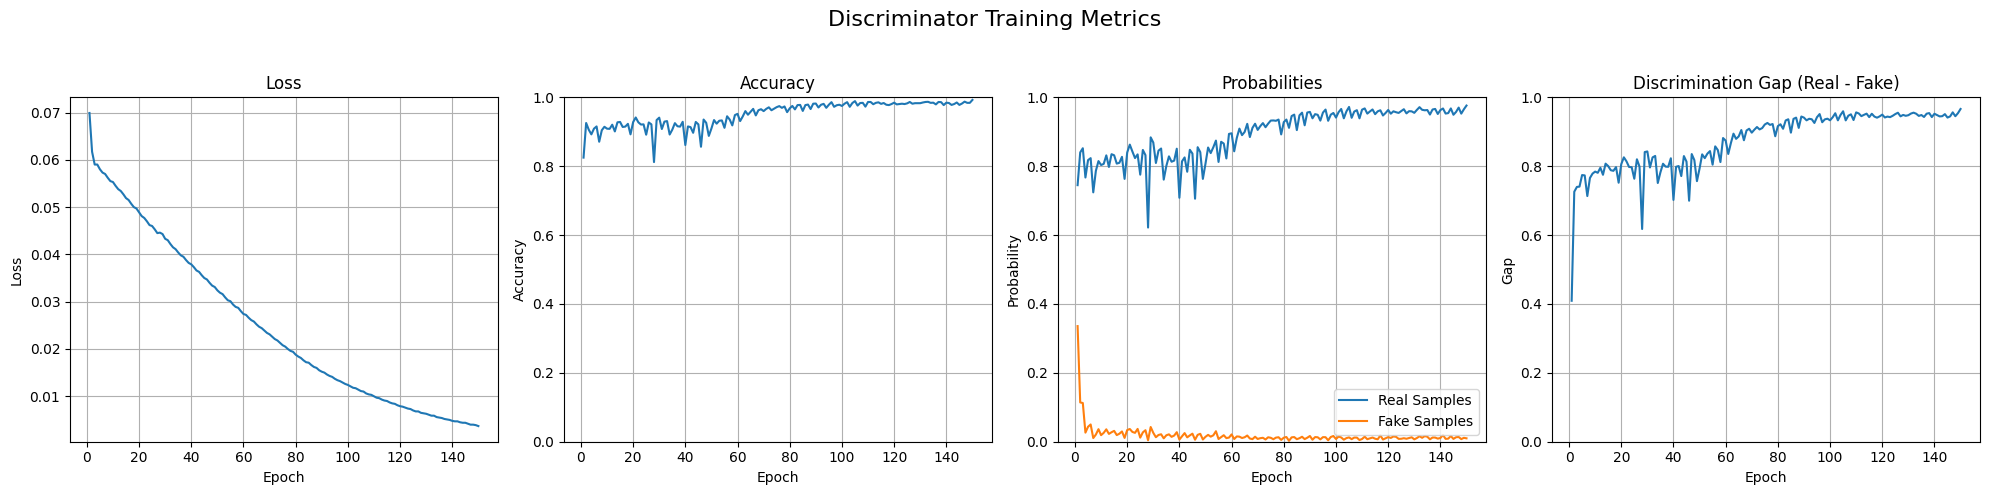

In [26]:
plot_discriminator_metrics()